# Homework 6
## Set environment

In [1]:
!uv init

Initialized project `homework-6`


In [2]:
!uv add scikit-learn
!uv add pandas
!uv add matplotlib
!uv add xgboost

Resolved 6 packages in 173ms                                         
Audited 5 packages in 4ms                                            
Resolved 11 packages in 111ms                                        
⠙                                                                               Audited 10 packages in 4ms
Resolved 19 packages in 114ms                                        
Audited 18 packages in 6ms                                           
Resolved 21 packages in 90ms                                         
Audited 19 packages in 1ms                                           


## Get data

In [3]:
!curl -O -L https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  853k  100  853k    0     0  3422k      0 --:--:-- --:--:-- --:--:-- 3428k


## Preparing the Dataset
Preparation:
* Fill missing values with zeros
* Do train/validation/test split with 60%/20%/20% distribution
* Use the `train_test_split` function and set the `random_seed` parameter to 1
* Use `DictVectorizer(sparse=True)` to turn the dataframes into matrices 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer 
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

# random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

# xgboost
import xgboost as xgb

In [5]:
data = pd.read_csv('car_fuel_efficiency.csv')
print(data.dtypes, data.isna().sum())
# there are no missing values in categorical columns
data = data.fillna(0)

engine_displacement      int64
num_cylinders          float64
horsepower             float64
vehicle_weight         float64
acceleration           float64
model_year               int64
origin                  object
fuel_type               object
drivetrain              object
num_doors              float64
fuel_efficiency_mpg    float64
dtype: object engine_displacement      0
num_cylinders          482
horsepower             708
vehicle_weight           0
acceleration           930
model_year               0
origin                   0
fuel_type                0
drivetrain               0
num_doors              502
fuel_efficiency_mpg      0
dtype: int64


In [6]:
y = data['fuel_efficiency_mpg']
data = data.drop(columns='fuel_efficiency_mpg')

df_full_train, df_test, y_full_train, y_test = train_test_split(data, y, test_size=0.2, random_state=1)
df_train, df_val, y_train, y_val = train_test_split(df_full_train, y_full_train, test_size=0.25, random_state=1)

# Question 1
Let's train a decision tree regressor to predict the `fuel_efficiency_mpg` variable
* Train a model with `max_depth = 1`

Which feature is used for splitting the data?

[Text(0.5, 0.75, 'vehicle_weight <= 3022.107\nsquared_error = 6.398\nsamples = 5822\nvalue = 14.994'),
 Text(0.25, 0.25, 'squared_error = 2.575\nsamples = 3034\nvalue = 16.882'),
 Text(0.375, 0.5, 'True  '),
 Text(0.75, 0.25, 'squared_error = 2.453\nsamples = 2788\nvalue = 12.938'),
 Text(0.625, 0.5, '  False')]

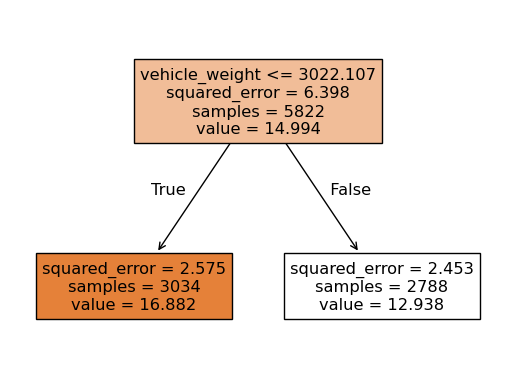

In [7]:
def train_dt(train, target, max_depth=None):
    dv = DictVectorizer(sparse = False)
    df_dict = train.to_dict(orient = 'records')
    X_train = dv.fit_transform(df_dict)
    model = DecisionTreeRegressor(max_depth = max_depth)
    model.fit(X_train, target)
    return dv, model

dv, model_dt = train_dt(df_train, y_train, max_depth = 1)
plot_tree(model_dt, feature_names = dv.get_feature_names_out(), filled = True)


# Question 2
Train a random forest regressor with these parameters:
* `n_estimators = 10`
* `random_state=1`
* `n_jobs=-1`

What's the RMSE of this model on the validation data?

In [8]:
def train_rf(train, target, n_estimators=10, random_state=1, n_jobs=-1, max_depth = None):
    dv = DictVectorizer(sparse = False)
    df_dict = train.to_dict(orient = 'records')
    X_train = dv.fit_transform(df_dict)
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state, n_jobs=n_jobs, max_depth=max_depth)
    model.fit(X_train, target)
    return dv, model

In [9]:
dv, model_rf = train_rf(df_train, y_train)
dict_val = df_val.to_dict(orient='records')
X_val = dv.transform(dict_val)
y_pred = model_rf.predict(X_val)
rmse = root_mean_squared_error(y_val, y_pred)

print(f'The RMSE on the validation data is {rmse}')

The RMSE on the validation data is 0.45997775573361477


# Question 3
Now let's experiment with the `n_estimators` parameter
* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

After which value of `n_estimators` does RMSE stop improving? Consider 3 decimal places for calculating the answer

In [10]:
score = []
for n in range(10, 201, 10):
    dv, model_rf = train_rf(df_train, y_train, n_estimators = n)
    dict_val = df_val.to_dict(orient='records')
    X_val = dv.transform(dict_val)
    y_pred = model_rf.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    score.append((n, rmse))

In [11]:
score = pd.DataFrame(score, columns = ['step', 'n_estimators'])

    step  n_estimators
0     10         0.460
1     20         0.454
2     30         0.451
3     40         0.448
4     50         0.446
5     60         0.445
6     70         0.445
7     80         0.445
8     90         0.445
9    100         0.444
10   110         0.443
11   120         0.444
12   130         0.443
13   140         0.443
14   150         0.443
15   160         0.443
16   170         0.443
17   180         0.442
18   190         0.443
19   200         0.443


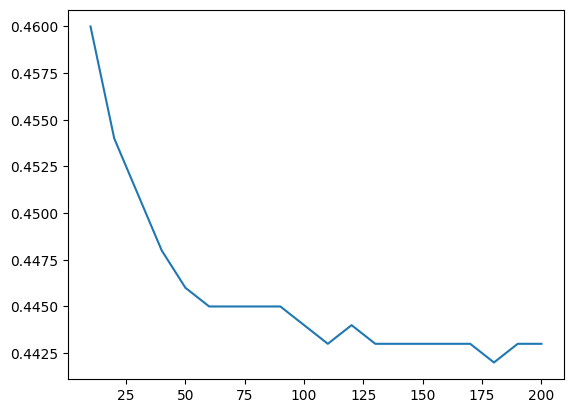

In [12]:
print(score.assign(n_estimators = score.n_estimators.round(3)))
plt.plot(score.step, score.n_estimators.round(3))

# Question 4
Let's select the best `max_depth`
* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of those values, 
    * Try different values of `n_estimators` from 10 to 200 with step 10
    * calculate the mean RMSE
* Fix the random seed: `random_state=1`

What's the best `max_depth`, using the mean RMSE?

In [13]:
score = []
for depth in [10, 15, 20, 25]:
    rmse=[]
    for n in range(10, 201, 10):
        dv, model_rf = train_rf(df_train, y_train, n_estimators = n, max_depth = depth)
        dict_val = df_val.to_dict(orient='records')
        X_val = dv.transform(dict_val)
        y_pred = model_rf.predict(X_val)
        rmse.append(root_mean_squared_error(y_val, y_pred))
    score.append((depth, list(zip(range(10, 201, 10), rmse)), np.mean(rmse)))

In [14]:
score = pd.DataFrame(score, columns = ['max_depth', 'rmse', 'mean_rmse'])

print(f'the best `max_depth` based on mean RMSE is {score['max_depth'][np.argmin(score['mean_rmse'])]}')

the best `max_depth` based on mean RMSE is 10


# Question 5
We can extract feature importance information from tree-based models.
At each step of the decision tree learning algorithm, it finds the best split. When doing it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the importance features for tree-based models.
In Sikit-Lean, tree-based models contain this information in the `feature_importances_` field.
For this homework question, we'll find the most important feature:

* Train the model with these parameters:
    * `n_estimators = 10`
    * `max_depth = 20`
    * `random_state = 1`
    * `n_jobs = -1`
* Get the feature importance information from this model

What's the most important feature?

In [15]:
dv, model_rf = train_rf(df_train, y_train, n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
dict_val = df_val.to_dict(orient='records')
X_val = dv.transform(dict_val)
y_pred = model_rf.predict(X_val)

In [16]:
feat_importance = list(
    zip(
        df_train.columns,
        model_rf.feature_importances_
    )
)
feat_importance = pd.DataFrame(feat_importance, columns = ['feature', 'importance']).sort_values('importance', ascending=True)

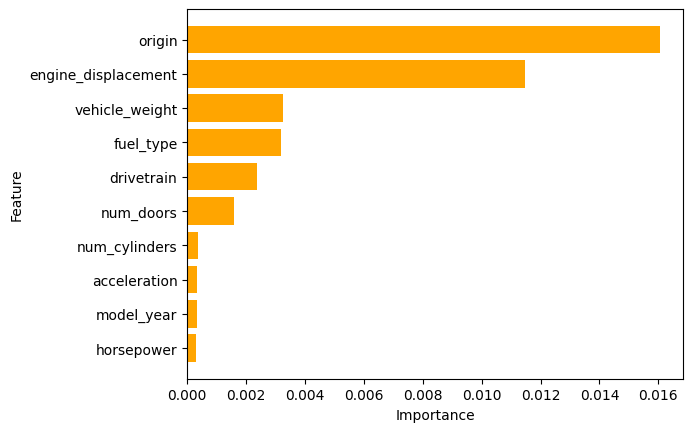

In [17]:
plt.barh(feat_importance['feature'], feat_importance['importance'], color='orange')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Question 6
Now let's train an XGBoost model. For this question, we'll tune the `eta` parameter:
* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:
```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`
Which `eta` leads to the best RMSE score on the validation dataset?

In [18]:
def train_xgb(train, target, val, y_val, params):
    dv = DictVectorizer(sparse = False)
    X_train = dv.fit_transform(train.to_dict(orient = 'records'))
    X_val = dv.transform(val.to_dict(orient = 'records'))

    features = list(dv.get_feature_names_out())
    dtrain = xgb.DMatrix(X_train, label = target, feature_names = features)
    dval = xgb.DMatrix(X_val, label = y_val, feature_names = features)

    watchlist = [(dtrain, 'train'), (dval, 'val')]
    model = xgb.train(
        params, 
        dtrain, 
        num_boost_round = 100, 
        evals = watchlist
        )
    return dval, model

In [19]:
%%capture output

score = []
for eta in [0.3, 0.1]:    
    xgb_params = {
        'eta': eta, 
        'max_depth': 6,
        'min_child_weight': 1,
        'objective': 'reg:squarederror',
        'nthread': 8,
        'seed': 1,
        'verbosity': 1
    }

    dval, model_xgb = train_xgb(df_train, y_train, val = df_val, y_val = y_val, params = xgb_params)
    y_pred = model_xgb.predict(dval)
    rmse = root_mean_squared_error(y_val, y_pred)
    score.append((eta, rmse))

    

In [20]:
score = pd.DataFrame(score, columns = ['eta', 'rmse'])

print(f'The `eta` with the best RMSE is {score.eta[np.argmin(score.rmse)]}')

The `eta` with the best RMSE is 0.1
